In [63]:
#Autoreload to be able to tweak source code in the fly without restarting kernel
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%autoreload 2

In [65]:
import aligater as ag

In [66]:
fcsList=ag.collectFiles("/media/ludvig/Project_Storage/GAIM/data/GAIM_fcs/", lFilter=["B cells", "Bcells","B_"])

Collected 3017 files, 6234 files did not pass filter(s) and mask(s).


In [152]:
fcsDF = ag.loadFCS(fcsList[101], compensate=True,markers=["IgA", "CD27" ,"CD34" ,"CD19", "IgD" ,"CD45","CD38","CD24"])

Opening file B cells_B2_B02_009 from folder /03-02-2016/plate 2
Loaded dataset with 500000 events.
Marker labels: IgA CD27 CD34 CD19 IgD CD45 CD38 CD24 


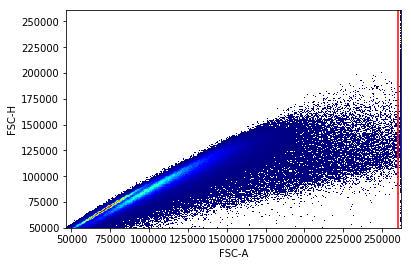

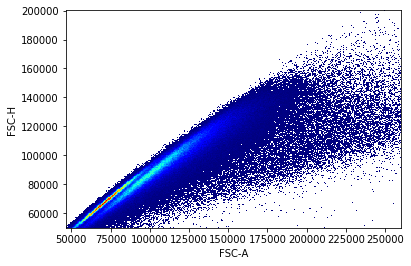

After gating, 494551 out of 500000 events remain.


In [153]:
no_clutter=ag.gateThreshold(fcsDF,"FSC-A", "FSC-H",thresh=260000, orientation='vertical',population="lower")

In [154]:
gmm=ag.gmm2D(fcsDF,"FSC-A","FSC-H",vI=no_clutter,nOfComponents=1)

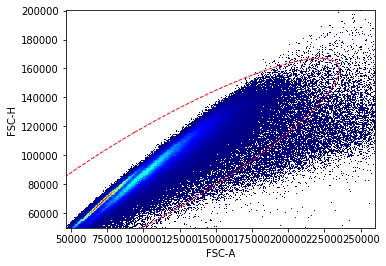

After gating, 481709 out of 494551 events remain.


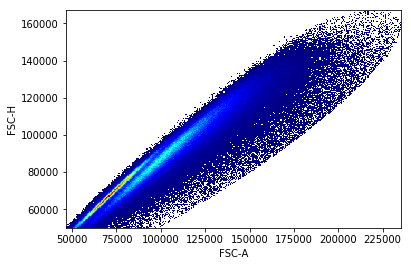

In [155]:
singlets=ag.gateGMM(fcsDF,"FSC-A","FSC-H",gmm=gmm,sigma=7,vI=no_clutter)

After gating, 483844 out of 494551 events remain.


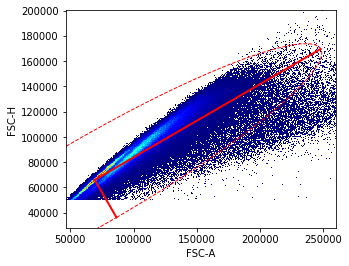

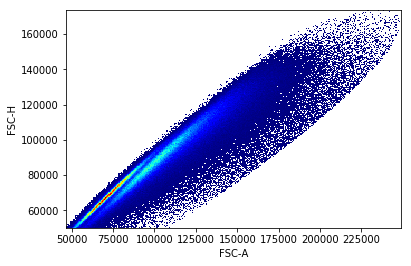

In [156]:
singlets=ag.gatePC(fcsDF,"FSC-A", "FSC-H",center='density',widthScale=5, heightScale=4, vI=no_clutter, plot=True)

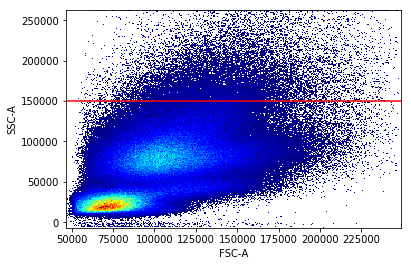

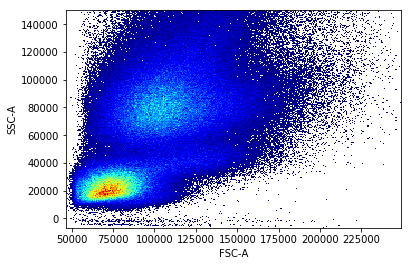

After gating, 453093 out of 483844 events remain.


In [157]:
PBMCstep1=ag.gateThreshold(fcsDF,xCol="FSC-A",yCol="SSC-A",vI=singlets, orientation="horisontal",thresh=150000,population="lower")

In [158]:
start=ag.getHighestDensityPoint(fcsDF,"FSC-A","SSC-A",vI=PBMCstep1)[1]
start

17256.865937499999

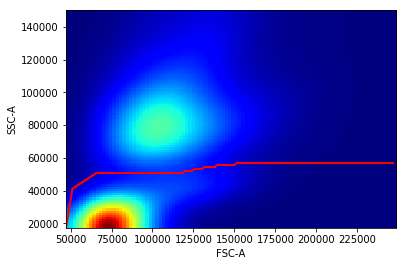

After gating, 172302 out of 453093 events remain.


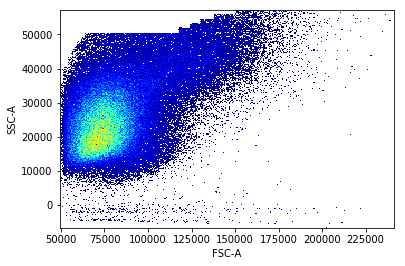

In [159]:
PBMCstep2=ag.shortestPath(fcsDF,"FSC-A","SSC-A",maxStep=10,sigma=4,boundaries=[start,150000],vI=PBMCstep1,bins=100)

In [160]:
gmm=ag.gmm2D(fcsDF,"FSC-A","SSC-A",2,PBMCstep2,tol=0.01)

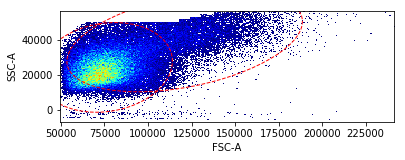

After gating, 171090 out of 172302 events remain.


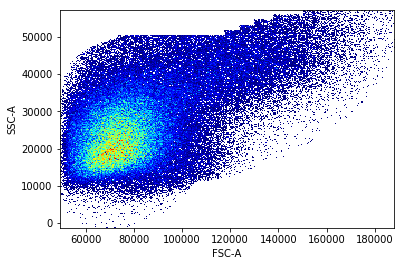

In [161]:
PBMC=ag.gateGMM(fcsDF,"FSC-A","SSC-A",gmm,PBMCstep2,sigma=6)

After gating, 171798 out of 172302 events remain.


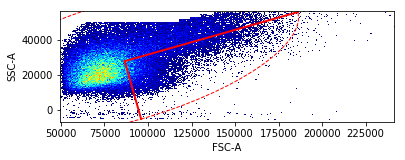

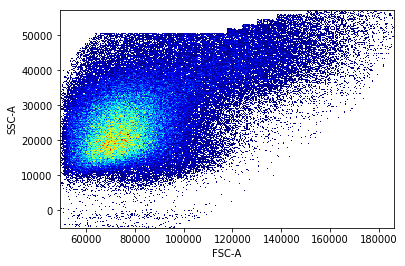

In [162]:
PBMC=ag.gatePC(fcsDF,"FSC-A","SSC-A",center='centroid',widthScale=4, heightScale=4, vI=PBMCstep2, plot=True)

In [ ]:
mean, sigma, maxVal=ag.axisStats(fcsDF, "CD34", PBMC,scale='logish')
sigma*2

In [ ]:
CD45step1 = ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="lower",thresh=2*sigma, scale='logish')

In [ ]:
lim = ag.valleySeek(fcsDF, "CD45",vI=CD45step1,interval=[0,2500],sigma=2,bins=1000)

In [ ]:
CD45pos = ag.gateThreshold(fcsDF, "CD34", "CD45", vI=CD45step1, orientation='horisontal',thresh=lim,scale='logish') 

In [ ]:
CD34step1=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='vertical', vI=PBMC,population="upper",thresh=2*sigma, scale='logish')

In [ ]:
ag.plot_densityFunc(fcsDF,"CD45", vI=CD34step1,sigma=4,bins=200, scale='logish')

In [ ]:
lim=ag.valleySeek(fcsDF, "CD45",vI=CD34step1,interval=[500,2500],sigma=2,bins=200,scale='logish')
lim

In [ ]:
CD34pos=ag.gateThreshold(fcsDF, "CD34", "CD45", orientation='horisontal', vI=CD34step1,population="lower",thresh=lim, scale='logish')

In [ ]:
ag.plotHeatmap(fcsDF, "CD19","CD45",vI=CD45pos,scale='logish')

In [ ]:
ag.plot_densityFunc(fcsDF,xCol="CD19",vI=CD45pos, bins=1000, sigma=2, scale='logish')

In [ ]:
lim=ag.valleySeek(fcsDF,xCol="CD19",vI=CD45pos,interval=[0,2000],bins=1000,sigma=2, scale='logish')

In [ ]:
lim

In [ ]:
CD19pos=ag.gateThreshold(fcsDF,"CD19","CD45",vI=CD45pos,thresh=lim,scale='logish',orientation='vertical',population='upper')

In [ ]:
ag.backGate(fcsDF,"FSC-A","SSC-A",PBMC,CD19pos)

In [ ]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=CD19pos,scale="logish",bins=300)

In [ ]:
xlim=ag.valleySeek(fcsDF,"IgD", CD19pos, interval=[500,2500],bins=300,sigma=2, scale='logish')

In [ ]:
ylim=ag.valleySeek(fcsDF,"CD27", CD19pos, interval=[500,1000],bins=300,sigma=2, scale='logish')

In [ ]:
solution = ag.variableQuadGate(fcsDF, "IgD", "CD27", [xlim, xlim, ylim, ylim], testRange=[2000,3000], position='left', vI=CD19pos,scale='logish',only_solution=True, plot=True, scoreThresh=0.6)

In [ ]:
switchB, preSwitchB, naiveB, exhaustedB,solution = ag.variableQuadGate(fcsDF, "IgD", "CD27", solution, testRange=[0,ylim], position='right', vI=CD19pos,scale='logish', plot=True)

In [ ]:
ag.plotHeatmap(fcsDF, "IgD", "CD27", vI=exhaustedB, scale='logish')

In [ ]:
mean, sigma, maxVal = ag.axisStats(fcsDF, "CD38", vI=switchB)

In [ ]:
ag.plot_densityFunc(fcsDF,"CD38",switchB,scale='logish',bins=300,sigma=2)

In [ ]:
def gatePlasmablasts(fcsDF, vI):
    solutions=[]
    for testThresh in range(2000,5000,500):
        plasmablasts,doublePos,tmp1,tmp2=ag.quadGate(fcsDF, "CD24", "CD38",1000,testThresh,vI=vI,scale='logish',plot=False)
        solutions.append([(len(plasmablasts)-len(doublePos)),testThresh])
    maxVal=-ag.np.inf
    maxThresh=testThresh
    for solution in solutions:
        if solution[0]>maxVal:
            maxVal=solution[0]
            maxThresh=solution[1]
    reportStr="best solution score: "+str(maxVal)+" with thresh: "+str(maxThresh)+"\n"
    ag.sys.stderr.write(reportStr)
    return maxThresh

In [ ]:
CD38thresh=gatePlasmablasts(fcsDF,switchB)

In [ ]:
plasmablasts=ag.gateCorner(fcsDF, "CD24", "CD38",1000,CD38thresh,"lower","upper", vI=switchB,scale='logish')

In [ ]:
xmean,xsigma,xmaxVal = ag.axisStats(fcsDF,xCol="CD24",vI=naiveB)

In [ ]:
ymean,ysigma,ymaxVal = ag.axisStats(fcsDF,xCol="CD38",vI=naiveB)

In [ ]:
[xmean, xsigma, xmaxVal]

In [ ]:
[ymean, ysigma, ymaxVal]

In [ ]:
transitionals=ag.gateCorner(fcsDF,"CD24", "CD38",xThresh = xmaxVal, yThresh=ymaxVal+2000, vI=naiveB, scale='logish')

In [ ]:
lim = ag.valleySeek(fcsDF,"IgA",vI=switchB,interval=[750,2000],bins=300, sigma=1, scale='logish')
lim

In [ ]:
IgApos=ag.gateThreshold(fcsDF, "IgA","CD19", orientation='vertical', vI=switchB, thresh=lim, scale='logish')